<a href="https://colab.research.google.com/github/miho777/RAG-PiperAI/blob/main/rag_piper03e.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. ハンズオン目的：RAGを体験する
### キーとなるコンポーネント：GPT(OpenAI社)とLlamaIndex(Meta社)

#2. RAG(Retrieval Augmented Generation:検索拡張生成)の位置づけ  
###   GenAI導入の選択肢

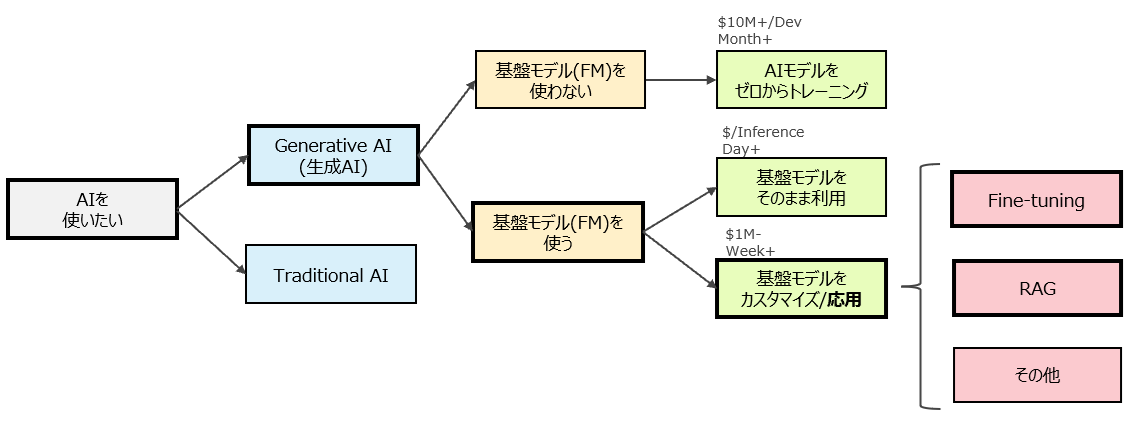

「主な選定要素」  
・コスト  
・期間  
・セキュリティ  
・インフラ  
・スキル  

###   RAG特性
#### Dellのサイトから抜粋した表：掘り下げて理解する（本RAGラボはGPU不要など）
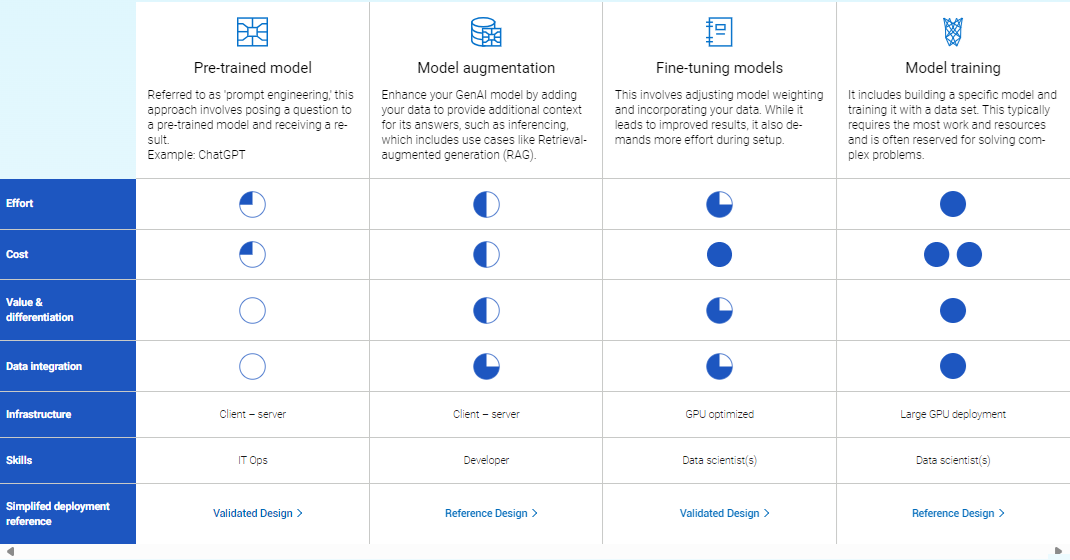

#3. RAGハンズオン構成

###抽象化した構成図

①②企業ドメイン情報をベクトル化しDBする  
③Userからの質問をベクトル化し、index検索/付加してGPTにプロンプト発行する  
④GPTが応答する  
  
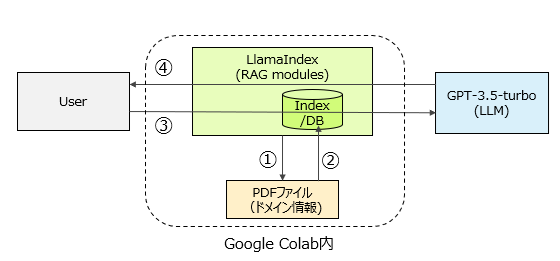

##ディスカッション：
####企業ドメイン情報はどこに保存されるか？   
####漏洩しないための考慮点は？  

#4. コード実行
#### ここからPythonコード実行スタート！

ライブラリのインストール

In [ ]:
!pwd
!pip install llama_index
!pip install llama-index-vector-stores-chroma
!pip install llama-index-readers-file pymupdf
!pip install llama-index-llms-openai
!pip install llama_index.core
!pip install --upgrade llama_index
!pip install openai

モジュールのインポート

In [ ]:
from llama_index.core import GPTVectorStoreIndex, ServiceContext
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core import Settings
from llama_index.core import download_loader
from llama_index.core import SimpleDirectoryReader
from llama_index.core import StorageContext, load_index_from_storage
from llama_index.readers.file import PyMuPDFReader
import os
import glob
from google.colab import auth
from google.colab import drive
from google.colab import output

LLM GPT-3.5利用のためのKey設定(*** 要キー入力 ***)

In [ ]:
### OpenAI API key設定
os.environ["OPENAI_API_KEY"] = input()
# API_KEYの出力抑止
output.clear()

Googleドライブ準備とRAG用企業ドメインデータのストア(*** 要ブラウザ認証 ***)

In [ ]:
### GoogleDriveマウント
# auth.authenticate_user()
drive.mount('/content/drive')

In [ ]:
### persistent directory設定
documents_path = "/content/drive/MyDrive/RAG_docs"
store_path = "/content/drive/MyDrive/RAG_store"


# RAG読込用フォルダ作成
if not os.path.exists(documents_path):
    os.makedirs(documents_path)
    print(f"フォルダ '{documents_path}' を作成")

# RAG検索DB用フォルダ作成
if not os.path.exists(store_path):
    os.makedirs(store_path)
    print(f"フォルダ '{store_path}' を作成")

# 企業DomainデータのLOAD（RAG読込用フォルダにStore）
!curl https://www.dell.com/en-us/blog/making-ai-easy-dell-enterprise-hub-on-hugging-face/ --output {documents_path}/Hug.htm
!curl https://infohub.delltechnologies.com/static/media/client/7phukh/DAM_5ac9daed-44a8-4379-9fcb-6c44317de537.pdf --output {documents_path}/Implementing_RAG_DellAPEXCloudPlatform_RedHatOpenShift.pdf


基盤モデル(GPT-3.5-turbo)やRAG(LlamaIndex)の準備

In [ ]:
### LLMやEmbeddingパラメータ設定
# FMの指定
Settings.llm = OpenAI(model="gpt-3.5-turbo", temperature=0, max_tokens=256)

# Embedding設定（RAG）
Settings.embed_model = OpenAIEmbedding(model="text-embedding-3-small")
Settings.node_parser = SentenceSplitter(chunk_size=512, chunk_overlap=20)
Settings.num_output = 512
Settings.context_window = 3900

RAGの EmbeddingとVectorDateのストア（IndexDB化）

In [ ]:
# PDFファイルのLOADとEmbedding（メモリ内処理）
documents = SimpleDirectoryReader(documents_path).load_data()
index = GPTVectorStoreIndex.from_documents(documents)

##ディスカッション：IndexDB永続化の意味は？

In [ ]:
### persistent（永続性）対応
# indexの保存
index.storage_context.persist(store_path)

### Indexs再読込み
# storage_context = StorageContext.from_defaults(persist_dir=store_path)
# index = load_index_from_storage(storage_context)

質問文の設定

In [ ]:
### 質問文の設定
query = "Dell Enterprise Hub on Hugging Faceに含まれる代表的なLLMは?"
# query = "What foundation model is Dell Enterprise Hub will include?"
# query = "Dell Enterprise Hub on Hugging Faceとは何ですか？ 日本語で回答して。 そのURLは？"
# query = "Where is The Dell Enterprise Hub will be globally available on May 21, 2024?"
# query = "Dell APEX Cloud Platform RedHat OpenShift について教えて？"
# query = "LiveOpticsの機能を日本語で説明して。またURLは？"

RAGの無い状態で推論してみる(RAG結果との比較用)

In [ ]:
### LLM推論(GPT-3.5ダイレクト) ###
print(query)
llm_response = OpenAI().complete(query)
print(llm_response)

RAGでの推論

In [ ]:
####### RAG推論(with GPT-3.5) #######
print(query)
res = index.as_query_engine().query(query)
print(res)

## RAGで企業ドメイン情報が得られることを確認する